# GitHub Push Exploration and Outlier Detection
## Matt Steele 11-16-2018

In this excercise we pull a set of push events from GetHub from public repositiories in order to investigate any outlier events. 

We are focused on two parameters of these push events:
    - The time between pushes
    - The number of commits in a push

Aberations from the push event population may indicate bottlenecks in the development process, and finding them may produce a avenue for increasing development efficiency.

### Pull Data from GItHub

We use the GitHub REST API to pull a set of recent events in public repositories and extract the repositories which have had recent push events.


In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

#--------- Get recent events -------------------------------------------------

resp  = requests.get('https://api.github.com/events')


In [2]:
#--------- Pull list of repositories for recent push events ------------------

repoURLs = []
for item in resp.json():
    if(item['type']=='PushEvent'):
        repoURLs.append(item['repo']['url']+ "/events")


From these repositories we then pull sets of recent push events and extract the number of distinct commits in a push event and timestamps of those push events.

In [108]:
#------------- get Push event sizes and times -------------------------

distinctSizes = []
timeStamps = []
repoNum = []
i = 0
for URL in repoURLs:
    eventLog = requests.get(URL)
    for item in eventLog.json():
        if(item['type']=='PushEvent'):
            distinctSizes.append(item['payload']['distinct_size'])
            timeStamps.append(item['created_at'])
            repoNum.append(i)
    i = i+1
    


### Data cleaning, formating

Once we have obtained the desired dataset we need to format in into a pandas dataframe and covert the timestamps into time intervals between commits.

In [37]:
#--------------- format dataframe -----------------------------

data = {'Repo':repoNum,'Time':timeStamps,'Size':distinctSizes}

githubDF = pd.DataFrame(data)
githubDF.iloc[:,2] = pd.to_datetime(githubDF.iloc[:,2])

# calculate time deltas between sequential push events
timeDeltas = githubDF.iloc[::-1].groupby('Repo')['Time'].apply(lambda x: (x-x.shift()).fillna(0)).iloc[::-1]

githubDF = githubDF.assign(tDelt=timeDeltas)
githubDF.iloc[:,3] = githubDF.iloc[:,3].dt.total_seconds()

githubDF.head()

,Repo,Size,Time,tDelt
0,0,1,2018-11-16 14:50:12,446.0
1,0,1,2018-11-16 14:42:46,1298.0
2,0,1,2018-11-16 14:21:08,822.0
3,0,1,2018-11-16 14:07:26,40758.0
4,0,1,2018-11-16 02:48:08,319.0


We can then perform a brief exploratory analyis on the data to develop an intuition on the nature and structure of the data. This exploratory analysis takes the form of calculating summary statistics and exploratory visualizations.

In [65]:
githubDF.iloc[:,[1,3]].describe()

,Size,tDelt
count,222.000000,2.220000e+02
mean,1.238739,5.194081e+04
std,1.134300,1.818052e+05
min,0.000000,0.000000e+00
25%,1.000000,9.275000e+01
50%,1.000000,9.675000e+02
75%,1.000000,2.574300e+04
max,12.000000,1.990604e+06


In [67]:
githubDF.groupby('Repo').describe()

Size                                               tDelt                 \
     count      mean       std  min  25%  50%  75%   max count           mean   
Repo                                                                            
0     14.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0  14.0   11496.071429   
1     28.0  1.285714  0.658682  1.0  1.0  1.0  1.0   4.0  28.0    1917.714286   
2      1.0  1.000000       NaN  1.0  1.0  1.0  1.0   1.0   1.0       0.000000   
3     20.0  2.500000  3.268671  0.0  1.0  1.5  3.0  12.0  20.0    6906.400000   
4      3.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0   3.0  722310.000000   
5      5.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0   5.0   99655.000000   
6     25.0  1.040000  0.200000  1.0  1.0  1.0  1.0   2.0  25.0  123965.720000   
7     30.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0  30.0    2699.733333   
8      5.0  1.400000  0.894427  1.0  1.0  1.0  1.0   3.0   5.0    6078.400000   
9     18.0  1.166667  0.618347  0.0  1.0  1.0  1.0   3.0  18.0   38801.111111   
10    13.0  1.153846  0.554700  1.0  1.0  1.0  1.0   3.0  13.0     278.461538   
11    10.0  1.100000  0.316228  1.0  1.0  1.0  1.0   2.0  10.0  251006.500000   
12    30.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0  30.0   66482.533333   
13     6.0  2.000000  1.549193  1.0  1.0  1.5  2.0   5.0   6.0   14703.833333   
14    14.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0  14.0     539.571429   

                                                                    
               std  min       25%       50%         75%        max  
Repo                                                                
0     1.558123e+04  0.0    482.25    2108.0    19664.75    40758.0  
1     3.894617e+03  0.0    131.75     427.5     1233.25    14654.0  
2              NaN  0.0      0.00       0.0        0.00        0.0  
3     1.368020e+04  0.0     84.25     738.5     5625.25    52737.0  
4     1.101907e+06  0.0  88163.00  176326.0  1083465.00  1990604.0  
5     9.852277e+04  0.0  33570.00   71322.0   147226.00   246157.0  
6     1.489465e+05  0.0  52543.00   86862.0   144105.00   692178.0  
7     1.134001e+04  0.0     10.25      53.5      774.50    62438.0  
8     1.195248e+04  0.0    369.00    1200.0     1388.00    27435.0  
9     6.933456e+04  0.0    878.75    4803.0    60717.75   250005.0  
10    4.823425e+02  0.0     17.00      43.0      131.00     1328.0  
11    3.961139e+05  0.0    338.50     760.5   412831.50  1211565.0  
12    1.437862e+05  0.0   5055.25   12372.5    66419.75   760509.0  
13    3.382782e+04  0.0    124.50     826.0     2426.75    83720.0  
14    1.277855e+03  0.0     70.00     141.0      265.25     4896.0

Text(0.5,0,'Time between pushes [log(s)]')

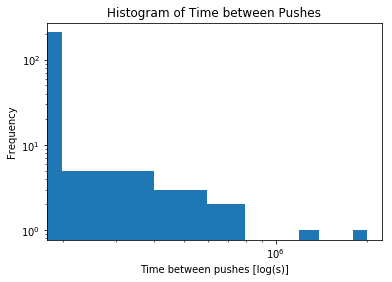

In [51]:
import matplotlib.pyplot as plt
githubDF.iloc[:,3].plot.hist(loglog=True,title='Histogram of Time between Pushes').set_xlabel('Time between pushes [log(s)]')

Text(0.5,0,'Commits in a Push')

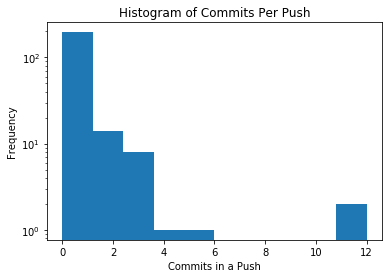

In [68]:
githubDF.iloc[:,1].plot.hist(logy=True,title='Histogram of Commits Per Push').set_xlabel('Commits in a Push')


Text(0.5,0,'Commits in a Push')

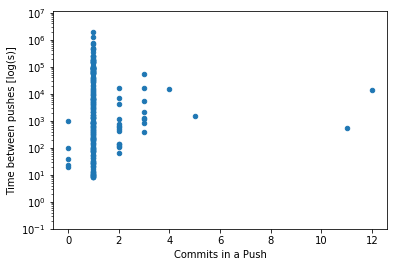

In [71]:
p3 = githubDF.plot.scatter(x='Size',y='tDelt',logy=True)
p3.set_ylim(bottom=0.1)
p3.set_ylabel('Time between pushes [log(s)]')
p3.set_xlabel('Commits in a Push')

### Outlier Detection

Following the exploratory analysis we can move onto determing which push events may be considered outliers. As a first pass to this we perform a z test for each parameter in the data set to find outliers in the time interval between pushes and in the number of commits between pushes.

A z test is not appropriate for the distributions of these two parameters, however it is still useful for developing understanding in which to ground subsequent more complex and statistically appropriate measures.

In [75]:
from scipy import stats

sizeIndex = stats.zscore(githubDF.iloc[:,1]) > 3.0
sizeIndex

githubDF.iloc[sizeIndex]

,Repo,Size,Time,tDelt
51,3,12,2018-11-15 17:29:36,13578.0
57,3,11,2018-11-15 11:57:44,526.0
204,13,5,2018-11-15 15:27:25,1514.0


In [76]:
timeIndex = stats.zscore(githubDF.iloc[:,3]) > 3.0
timeIndex

githubDF.iloc[timeIndex]

,Repo,Size,Time,tDelt
64,4,1,2018-11-14 13:44:00,1990604.0
92,6,1,2018-10-23 07:11:34,692178.0
165,11,1,2018-11-16 14:15:37,1211565.0
193,12,1,2018-11-09 10:38:59,760509.0


We now move on to a multivariate nonparametric tests to present a more sophisticated analysis. In this case we will use the "Dbscan" denisty based cluster method. This approach builds cluster by assuming that clusters are defined by parameter space density distributions. Any points that do not live in sufficiently dense regions of parameter space are outliers.

The first step a Dbscan analysis is to normalize the data so that all dimensions are weighted equaly when clusters are constructed.

In [84]:
from sklearn import preprocessing

#setup data scaler
mmScaler = preprocessing.MinMaxScaler()

scaledDF = mmScaler.fit_transform(githubDF[['Size','tDelt']])
scaledDF = pd.DataFrame(scaledDF,columns=['Size','tDelt'])
scaledDF.head()
#mmScaler.fit_transform(githubDF.iloc[:,3].values)

,Size,tDelt
0,0.083333,0.000224
1,0.083333,0.000652
2,0.083333,0.000413
3,0.083333,0.020475
4,0.083333,0.000160


(1e-06, 11.220184543019636)

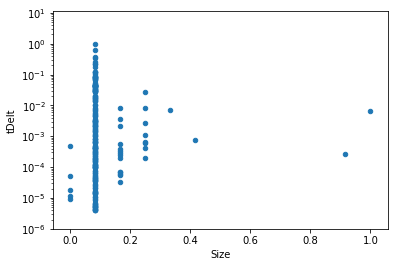

In [93]:
scaledDF.plot.scatter(x='Size',y='tDelt',logy=True).set_ylim(bottom=0.000001)

Once the data is normalized and rescaled we can fit clusters to the data set and determine which data points lie outside the clusters.

In [103]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.3,min_samples=10).fit(scaledDF)
labels = db.labels_
outlierIndex = labels == -1
memberIndex = labels != -1

githubDF.iloc[outlierIndex]

,Repo,Size,Time,tDelt
51,3,12,2018-11-15 17:29:36,13578.0
57,3,11,2018-11-15 11:57:44,526.0
64,4,1,2018-11-14 13:44:00,1990604.0


Text(0.5,0,'Commits in a Push')

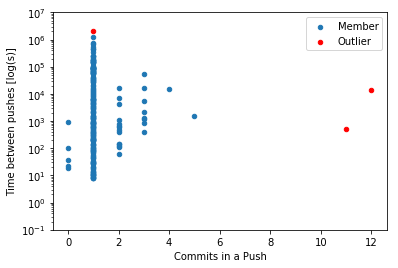

In [107]:
p3 = githubDF.iloc[memberIndex].plot.scatter(x='Size',y='tDelt',logy=True,label='Member')
githubDF.iloc[outlierIndex].plot.scatter(x='Size',y='tDelt',logy=True,label='Outlier',color='red',ax=p3)
p3.set_ylim(bottom=0.1,top=1e7)
p3.set_ylabel('Time between pushes [log(s)]')
p3.set_xlabel('Commits in a Push')